In [1]:
#!pipenv install blackcellmagic --dev
#!pipenv install seaborn

In [1]:
%load_ext blackcellmagic

In [2]:
from CrawtoML import CrawtoML
import pandas
df = pandas.read_csv("train.csv")

In [17]:
automl = CrawtoML(
    data=df,
    target="Survived",
    problem='classification'
)

In [5]:
automl

	Target Column: Survived 
        Problematic Columns: ['PassengerId', 'Cabin']
        Categorical Columns: ['imputed_Embarked', 'Pclass', 'Sex', 'SibSp', 'Parch']
        Encoded Categorical Features: ['imputed_Embarked_te', 'Pclass_te', 'Sex_te', 'SibSp_te', 'Parch_te']
        Numeric Columns: ['imputed_Age', 'Fare']
        Transformed Numeric Columns: ['imputed_Age_log', 'imputed_Age_boxcox', 'imputed_Age_yeo', 'Fare_yeo', 'imputed_Age_inverted']
        Imputed Columns: ['imputed_Age', 'imputed_Embarked']
        NAN Columns:     ['Age', 'Embarked']

In [6]:
automl.nan_report()

,Percent of data encoded NAN
PassengerId,0.00
Survived,0.00
Pclass,0.00
Name,0.00
Sex,0.00
Age,19.87
SibSp,0.00
Parch,0.00
Ticket,0.00
Fare,0.00


In [7]:
automl.data.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

AxesSubplot(0.125,0.125;0.775x0.755)


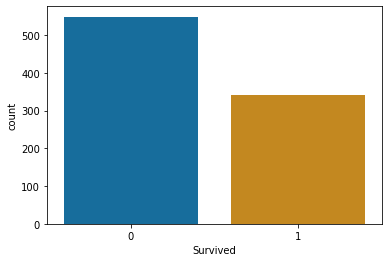

In [8]:
automl.target_distribution_report()

No Features are correlated above the threshold


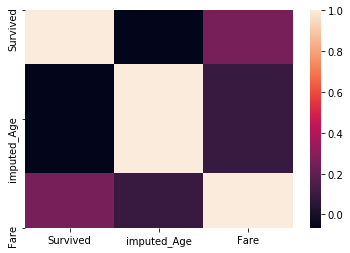

In [9]:
automl.correlation_report()

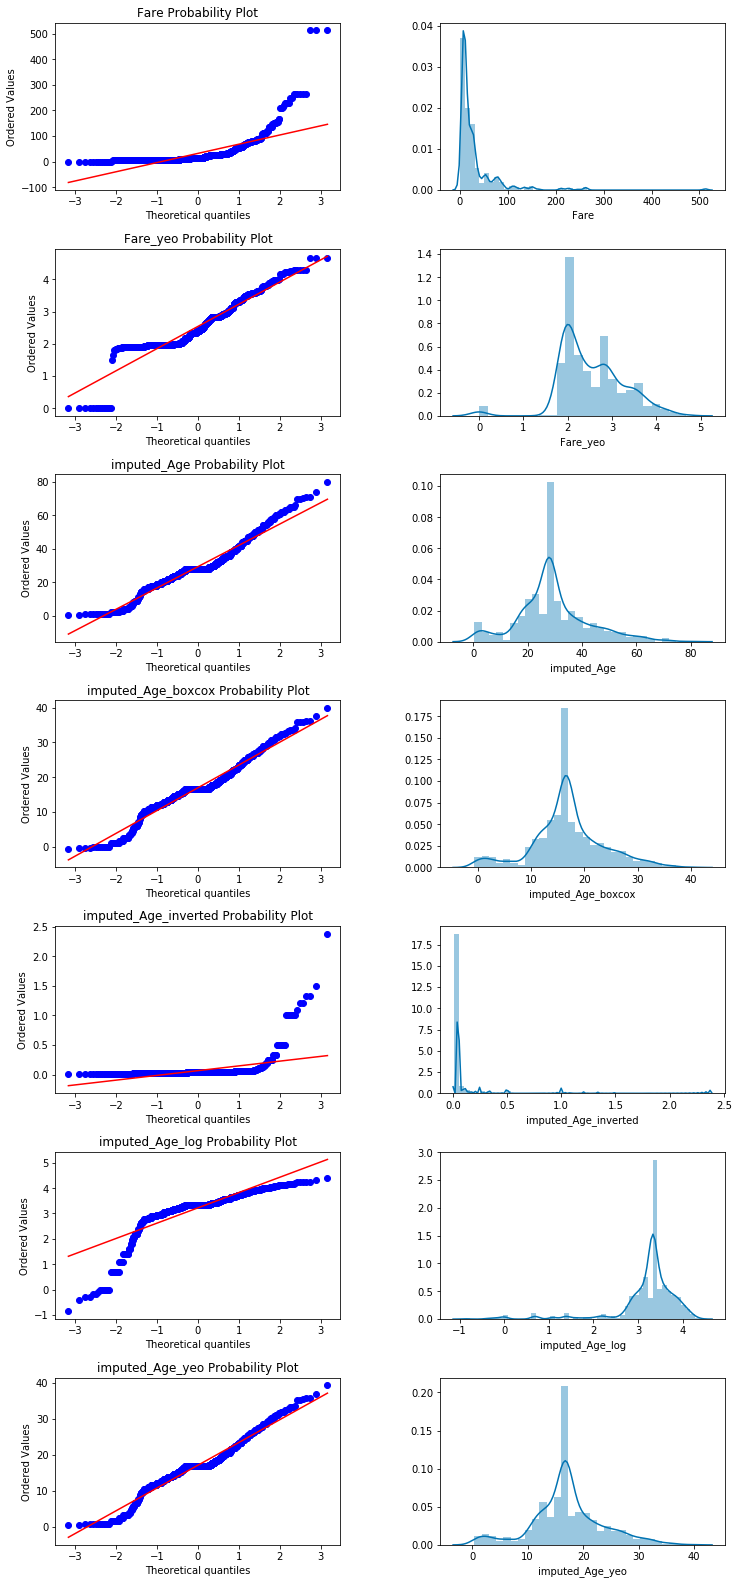

In [10]:
automl.probability_plots()

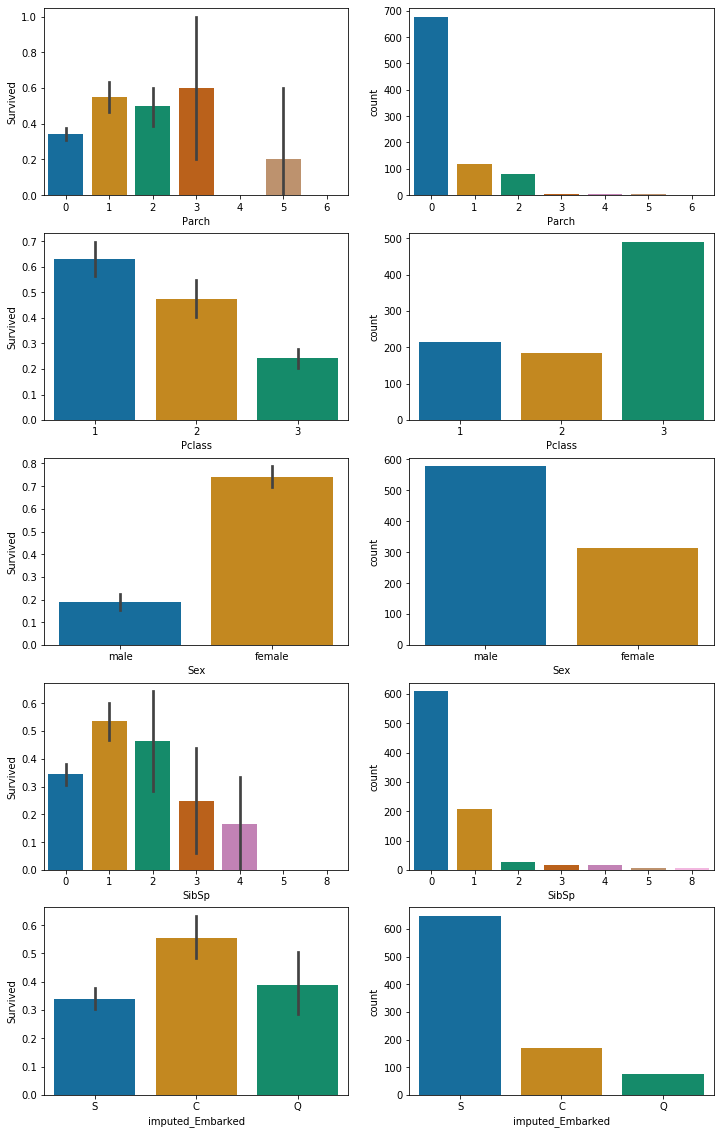

In [11]:
automl.categorical_bar_plots()

In [12]:
automl.distribution_r()

,Shapiro-Wilks_Test_Statistic,Shapiro-Wilks_p_Value,Normal distribution ?
imputed_Age,0.954105,4.650938e-16,False
Fare,0.521891,1.079000e-43,False
Survived,0.616660,1.794531e-40,False


# Experiments

### Notes
normal_test  

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
from math import ceil
import pandas as pd
from scipy.stats import shapiro, boxcox, yeojohnson
from scipy.stats import probplot
from sklearn.preprocessing import LabelEncoder,PowerTransformer
from category_encoders.target_encoder import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_transformer

sns.set_palette("colorblind")


class CrawtoML:
    def __init__(self, data, target, features="infer", problem="infer"):
        self.input_data = data
        self.target = target
        self.nan_features = []
        self.categorical_features = []
        self.encoded_features = []
        self.problematic_columns = []
        self.numeric_features = []
        if features == "infer":
            self.undefined_features = list(self.input_data.columns)
            self.undefined_features.remove(self.target)
        # TODO elif
        if problem in ["classification", "regression"]:
            self.problem = problem
        else:
            # TODO infer
            raise Exception("problem=infer not implemented")
        self.define_problematic_features()
        self.define_nan_features()
        self.define_numeric_features()
        self.transformed_numeric_features = self.numeric_features
        self.define_categorical_features()
        self.transformed_categorical_features = self.categorical_features
        self.transformed_data = pd.DataFrame(
            data=self.input_data[self.numeric_features + self.categorical_features],
            columns=self.numeric_features + self.categorical_features,
        )
        self.transformed_features_dictionary = {}
        self.create_transformed_features_dictionary_and_lists()
        pipeline = self.create_pipeline()
        #self.pipe_test = pipeline.fit(self.transformed_data)
        
    def define_numeric_features(self):
        to_numeric_features = []
        l = self.undefined_features
        to_remove = []
        for i in l:
            if self.input_data[i].dtype in ["float64"]:
                to_numeric_features.append(i)
                to_remove.append(i)
        self.numeric_features = to_numeric_features
        for j in to_remove:
            self.undefined_features.remove(j)

    def define_categorical_features(self, threshold=10):
        to_categorical_features = []
        to_remove = []
        l = self.undefined_features
        for i in self.undefined_features:
            if len(self.input_data[i].value_counts()) / len(self.input_data[i]) < 0.10:
                to_categorical_features.append(i)
                to_remove.append(i)
        self.categorical_features = to_categorical_features
        for j in to_remove:
            self.undefined_features.remove(j)

    def define_nan_features(self):
        l = self.undefined_features
        to_remove = []
        for i in l:
            if self.input_data[i].isna().sum() / len(self.input_data[i]) > 0.25:
                self.problematic_columns.append(i)
                to_remove.append(i)
        for j in to_remove:
            self.undefined_features.remove(j)

    def define_problematic_features(self):
        to_remove = []
        for i in self.undefined_features:
            if "Id" in i:
                self.problematic_columns.append(i)
                to_remove.append(i)
            elif "ID" in i:
                self.problematic_columns.append(i)
                to_remove.append(i)
        for i in to_remove:
            self.undefined_features.remove(i)

    def create_transformed_features_dictionary_and_lists(self):
        self.box_cox_features = []
        self.yeo_johnson_features = []
        self.log_transform_features = []
        self.inverse_transform_features = []
        transforms = ["box_cox", "yeo_johnson", "log_transform", "inverse_transform"]
        l = self.transformed_numeric_features.copy()
        for feature in l:
            self.transformed_features_dictionary[feature] = [
                i + "_" + feature for i in transforms
            ]

            self.box_cox_features.append("box_cox_" + feature)
            self.transformed_numeric_features.append("box_cox_" + feature)

            self.yeo_johnson_features.append("yeo_johnson_" + feature)
            self.transformed_numeric_features.append("yeo_johnson_" + feature)

            self.log_transform_features.append("log_transform_" + feature)
            self.transformed_numeric_features.append("log_transform_" + feature)

            self.inverse_transform_features.append("inverse_transform_" + feature)
            self.transformed_numeric_features.append("inverse_transform_" + feature)

        self.label_encoded_features = []
        self.target_encoded_features = []
        transforms = ["label_encoded", "target_encoded"]
        l = self.categorical_features.copy()
        for feature in l:
            self.transformed_features_dictionary[feature] = [
                i + "_" + feature for i in transforms
            ]

            self.label_encoded_features.append("label_encoded_" + feature)
           
            self.transformed_categorical_features.append("label_encoded_" + feature)

            self.target_encoded_features.append("target_encoded_" + feature)
            
            self.transformed_categorical_features.append("target_encoded_" + feature)

    def create_pipeline(self):
        numeric_imputer = Pipeline(
            steps=[("numeric_imputer", SimpleImputer(strategy="median",copy=False))]
        )
        categorical_imputer = Pipeline(
            steps=[
                ("categorical_imputer", SimpleImputer(strategy="most_frequent",copy=False))]
        )
        yeo_johnson_pipe = Pipeline(
            steps=[
                ("yeo_johnson", PowerTransformer(method='yeo_johnson',copy=False))
            ]
        )
        impute_transform = ColumnTransformer(
            transformers=[
                (
                    "numeric_imputer",
                    numeric_imputer,
                    self.transformed_numeric_features,
                ),
                (
                    "categorical_imputer",
                    categorical_imputer,
                    self.transformed_categorical_features,
                ),
            ]
        )
        numeric_transform = ColumnTransformer(
            transformers = [
                ('yeo_johnson_transform', yeo_johnson_pipe, self.yeo_johnson_features)
            ])
        pipeline = Pipeline(steps=[
            ('imputer',impute_transform),
            ('numeric_transform',numeric_transform)
        ])
        return pipeline

    def __repr__(self):
        return f"\tTarget Column: {self.target} \n\
        Problematic Columns: {self.problematic_columns}\n\
        Categorical Columns: {self.categorical_features}\n\
        Numeric Columns: {self.numeric_features}\n\
        UnDefined Columns: {self.undefined_features}\n\
        NAN Columns:     {self.nan_features}"


In [4]:
test = CrawtoML(
    data=df,
    target="Survived",
    problem='classification'
)

In [5]:
test.transformed_numeric_features

['Age',
 'Fare',
 'box_cox_Age',
 'yeo_johnson_Age',
 'log_transform_Age',
 'inverse_transform_Age',
 'box_cox_Fare',
 'yeo_johnson_Fare',
 'log_transform_Fare',
 'inverse_transform_Fare']

In [6]:
test.transformed_categorical_features

['Pclass',
 'Sex',
 'SibSp',
 'Parch',
 'Embarked',
 'label_encoded_Pclass',
 'target_encoded_Pclass',
 'label_encoded_Sex',
 'target_encoded_Sex',
 'label_encoded_SibSp',
 'target_encoded_SibSp',
 'label_encoded_Parch',
 'target_encoded_Parch',
 'label_encoded_Embarked',
 'target_encoded_Embarked']

In [7]:
test.transformed_data

,Age,Fare,Pclass,Sex,SibSp,Parch,Embarked,box_cox_Age,yeo_johnson_Age,log_transform_Age,...,label_encoded_Pclass,target_encoded_Pclass,label_encoded_Sex,target_encoded_Sex,label_encoded_SibSp,target_encoded_SibSp,label_encoded_Parch,target_encoded_Parch,label_encoded_Embarked,target_encoded_Embarked
0,22.0,7.2500,3,male,1,0,S,22.0,22.0,22.0,...,3,3,male,male,1,1,0,0,S,S
1,38.0,71.2833,1,female,1,0,C,38.0,38.0,38.0,...,1,1,female,female,1,1,0,0,C,C
2,26.0,7.9250,3,female,0,0,S,26.0,26.0,26.0,...,3,3,female,female,0,0,0,0,S,S
3,35.0,53.1000,1,female,1,0,S,35.0,35.0,35.0,...,1,1,female,female,1,1,0,0,S,S
4,35.0,8.0500,3,male,0,0,S,35.0,35.0,35.0,...,3,3,male,male,0,0,0,0,S,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,13.0000,2,male,0,0,S,27.0,27.0,27.0,...,2,2,male,male,0,0,0,0,S,S
887,19.0,30.0000,1,female,0,0,S,19.0,19.0,19.0,...,1,1,female,female,0,0,0,0,S,S
888,NaN,23.4500,3,female,1,2,S,NaN,NaN,NaN,...,3,3,female,female,1,1,2,2,S,S
889,26.0,30.0000,1,male,0,0,C,26.0,26.0,26.0,...,1,1,male,male,0,0,0,0,C,C


In [13]:
dir(test)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'box_cox_features',
 'categorical_features',
 'create_pipeline',
 'create_transformed_features_dictionary_and_lists',
 'define_categorical_features',
 'define_nan_features',
 'define_numeric_features',
 'define_problematic_features',
 'encoded_features',
 'input_data',
 'inverse_transform_features',
 'label_encoded_features',
 'log_transform_features',
 'nan_features',
 'numeric_features',
 'problem',
 'problematic_columns',
 'target',
 'target_encoded_features',
 'transformed_categorical_features',
 'transformed_data',
 'transformed_features_dictionary',
 'transformed_numeric_features',
 'undefined_features',
 'yeo_johns

In [16]:
numeric_imputer = Pipeline(
            steps=[("numeric_imputer", SimpleImputer(strategy="median",copy=False))]
        )
categorical_imputer = Pipeline(
    steps=[
        ("categorical_imputer", SimpleImputer(strategy="most_frequent",copy=False))]
)
# yeo_johnson_pipe = Pipeline(
#     steps=[
#         ("yeo_johnson", PowerTransformer(method='yeo_johnson',copy=False))
#     ]
# )
impute_transform = ColumnTransformer(
    transformers=[
        ("numeric_imputer",
         SimpleImputer(strategy="median",copy=False),
        test.transformed_numeric_features
        ),
        (
            "categorical_imputer",
            SimpleImputer(strategy="most_frequent",copy=False),
            test.transformed_categorical_features,
        ),
        ("yeo_johnson",
         PowerTransformer(method='yeo-johnson',copy=False),
         test.yeo_johnson_features
        )
    ]
)
# numeric_transform = ColumnTransformer(
#     transformers = [
#         ('yeo_johnson_transform', yeo_johnson_pipe, test.yeo_johnson_features)
#     ])
# fu_sklearn = FeatureUnion([
#     ('imputer',impute_transform),
#     ('numeric_transform',numeric_transform)
# ])

In [19]:
pd.DataFrame(impute_transform.fit_transform(test.transformed_data))

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0,22,7.25,22,22,22,22,7.25,7.25,7.25,7.25,...,male,male,1,1,0,0,S,S,-0.472172,-0.87882
1,38,71.2833,38,38,38,38,71.2833,71.2833,71.2833,71.2833,...,female,female,1,1,0,0,C,C,0.605017,1.33665
2,26,7.925,26,26,26,26,7.925,7.925,7.925,7.925,...,female,female,0,0,0,0,S,S,-0.189376,-0.790065
3,35,53.1,35,35,35,35,53.1,53.1,53.1,53.1,...,female,female,1,1,0,0,S,S,0.412768,1.06735
4,35,8.05,35,35,35,35,8.05,8.05,8.05,8.05,...,male,male,0,0,0,0,S,S,0.412768,-0.774439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27,13,27,27,27,27,13,13,13,13,...,male,male,0,0,0,0,S,S,-0.120309,-0.294907
887,19,30,19,19,19,19,30,30,30,30,...,female,female,0,0,0,0,S,S,-0.692126,0.527906
888,28,23.45,28,28,28,28,23.45,23.45,23.45,23.45,...,female,female,1,1,2,2,S,S,NaN,0.288885
889,26,30,26,26,26,26,30,30,30,30,...,male,male,0,0,0,0,C,C,-0.189376,0.527906


AttributeError: Transformer numeric_imputer (type SimpleImputer) does not provide get_feature_names.

In [ ]:
def correlation_report(self):
        sns.heatmap(self.data[self.numeric_features].corr())

    def target_distribution_report(self):
        if self.problem == "regression":
            print(sns.distplot(self.data[self.target]))
        elif self.problem == "classification":
            print(sns.countplot(self.data[self.target]))

    def numeric_columns_distribution_report(self):
        self.distribution_r()

    #         print(
    #             sns.PairGrid(
    #                 self.data, x_vars=self.numeric_features, y_vars=self.target
    #             ).map(sns.distplot)
    #         )

    def distribution_r(self):
        display(
            pandas.DataFrame(
                [
                    self.distribution_fit(self.data, i)
                    for i in self.numeric_features + [self.target]
                ],
                index=self.numeric_features + [self.target],
            )
        )

    def distribution_fit(self, data, numeric_features):
        """
        x is a column_name
        """
        shapiro_values = shapiro(data[numeric_features])
        test_indication = True if shapiro_values[1] > 0.05 else False

        distribution_types = ["norm", "expon", "logistic", "gumbel"]
        # anderson_values = anderson(automl.data[numeric_column], dist=i)

        return {
            "Shapiro-Wilks_Test_Statistic": shapiro_values[0],
            "Shapiro-Wilks_p_Value": shapiro_values[1],
            "Normal distribution ?": test_indication
            # "Anderson_Darling_Test_Statistic_Normal": anderson_values[0][0],
        }

    def nan_report(self):
        display(
            pandas.DataFrame(
                round((self.data.isna().sum() / self.data.shape[0]) * 100, 2),
                columns=["Percent of data encoded NAN"],
            )
        )

    def correlation_report(self, threshold=0.95):
        corr_matrix = self.data[[self.target] + self.numeric_features].corr()
        upper = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)
        )
        highly_correlated_features = [
            column for column in upper.columns if any(upper[column] > threshold)
        ]
        sns.heatmap(corr_matrix)
        if len(highly_correlated_features) > 0:
            print(f"Highly Correlated features are {highly_correlated_features}")
        else:
            print("No Features are correlated above the threshold")

    def probability_plots(self):
        c = self.numeric_features + self.transformed_numeric_features
        c.sort()
        fig = plt.figure(figsize=(12, len(c) * 4))
        fig.tight_layout()
        chart_count = 1
        for i in range(1, (len(c) + 1), 1):
            fig.add_subplot(len(c), 2, chart_count)
            chart_count += 1
            probplot(self.data[c[i - 1]], plot=plt)
            plt.subplots_adjust(
                left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=0.35
            )
            plt.title(c[i - 1] + " Probability Plot")
            fig.add_subplot(len(c), 2, chart_count)
            chart_count += 1
            sns.distplot(self.data[c[i - 1]])
        plt.show()

    def categorical_bar_plots(self):
        c = self.categorical_features
        c.sort()
        fig = plt.figure(figsize=(12, len(c) * 4))
        fig.tight_layout()
        chart_count = 1
        for i in range(1, len(c) + 1):
            fig.add_subplot(len(c), 2, chart_count)
            sns.barplot(x=c[i - 1], y=self.target, data=self.data)
            chart_count += 1
            fig.add_subplot(len(c), 2, chart_count)
            sns.countplot(x=c[i - 1], data=self.data)
            chart_count += 1

    def baseline_prediction(self):
        if self.problem == "classification":
            pass
        if self.problem == "regression":
            pass

In [ ]:
test.undefined_features

In [35]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,imputed_Age_log,imputed_Age_boxcox,imputed_Age_yeo,Fare_yeo,imputed_Age_inverted,imputed_Embarked_te,Pclass_te,Sex_te,SibSp_te,Parch_te
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,3.091042,13.468119,13.788503,1.906724,0.045455,0.339009,3,0.188908,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,3.637586,21.498728,21.575367,3.497640,0.026316,0.553571,1,0.742038,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,3.258097,15.563417,15.820085,1.970459,0.038462,0.339009,3,0.742038,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,3.555348,20.056110,20.176650,3.304258,0.028571,0.339009,1,0.742038,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,3.555348,20.056110,20.176650,1.981680,0.028571,0.339009,3,0.188908,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,...,3.295837,16.076643,16.317761,2.326029,0.037037,0.339009,2,0.188908,0,0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,...,2.944439,11.845513,12.215755,2.916885,0.052632,0.339009,1,0.742038,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,...,3.332205,16.586014,16.811708,2.745246,0.035714,0.339009,3,0.742038,1,2
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,...,3.258097,15.563417,15.820085,2.916885,0.038462,0.553571,1,0.188908,0,0


In [44]:
le = LabelEncoder()
pd.DataFrame(le.fit_transform(df.Sex)).isna().sum()

0    0
dtype: int64

In [42]:
df.isna().sum()

PassengerId               0
Survived                  0
Pclass                    0
Name                      0
Sex                       0
Age                     177
SibSp                     0
Parch                     0
Ticket                    0
Fare                      0
Cabin                   687
Embarked                  2
imputed_Age               0
imputed_Embarked          0
imputed_Age_log           0
imputed_Age_boxcox        0
imputed_Age_yeo           0
Fare_yeo                  0
imputed_Age_inverted      0
imputed_Embarked_te       0
Pclass_te                 0
Sex_te                    0
SibSp_te                  0
Parch_te                  0
dtype: int64